In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
# NLP
from bs4 import BeautifulSoup
import string
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

# Loading the dataset

In [3]:
df= pd.read_csv("train.csv")
to_test = pd.read_csv("test.csv")

In [4]:
df.describe(include='all')

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score
count,32165.000000,32165,32165,32165,32165.000000,32165,32165.000000,32165.000000
unique,NaN,2220,636,30121,NaN,3537,NaN,NaN
top,NaN,Levonorgestrel,Birth Control,"""Good""",NaN,20-Jan-16,NaN,NaN
freq,NaN,724,5795,8,NaN,37,NaN,NaN
mean,115487.511052,NaN,NaN,NaN,6.998912,NaN,27.893207,6.664261
std,67146.156602,NaN,NaN,NaN,3.274781,NaN,35.819035,1.588699
min,9.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,0.899076
25%,56922.000000,NaN,NaN,NaN,5.000000,NaN,6.000000,6.109307
50%,115776.000000,NaN,NaN,NaN,8.000000,NaN,16.000000,6.788245
75%,173562.000000,NaN,NaN,NaN,10.000000,NaN,36.000000,7.900790


In [5]:
to_test.head(5)

,patient_id,name_of_drug,review_by_patient,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug,effectiveness_rating
0,163740,Mirtazapine,"""I&#039;ve tried a few antidepressants over th...",28-Feb-12,22,Depression,10
1,39293,Contrave,"""Contrave combines drugs that were used for al...",5-Mar-17,35,Weight Loss,9
2,208087,Zyclara,"""4 days in on first 2 weeks. Using on arms an...",3-Jul-14,13,Keratosis,4
3,23295,Methadone,"""Ive been on Methadone for over ten years and ...",18-Oct-16,21,Opiate Withdrawal,7
4,97013,Ambien,"""Ditto on rebound sleepless when discontinued....",13-Jan-15,44,Insomnia,2


# Text Features

# Punctuations

In [6]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

df['review_by_patient'] = df['review_by_patient'].apply(punctuation_removal)
to_test['review_by_patient'] = to_test['review_by_patient'].apply(punctuation_removal)

In [7]:
to_test.head(5)

,patient_id,name_of_drug,review_by_patient,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug,effectiveness_rating
0,163740,Mirtazapine,I039ve tried a few antidepressants over the ye...,28-Feb-12,22,Depression,10
1,39293,Contrave,Contrave combines drugs that were used for alc...,5-Mar-17,35,Weight Loss,9
2,208087,Zyclara,4 days in on first 2 weeks Using on arms and ...,3-Jul-14,13,Keratosis,4
3,23295,Methadone,Ive been on Methadone for over ten years and c...,18-Oct-16,21,Opiate Withdrawal,7
4,97013,Ambien,Ditto on rebound sleepless when discontinued I...,13-Jan-15,44,Insomnia,2


# Stopwords Removal

In [8]:
stop = stopwords.words('english')
stop.append("i'm")

stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 

def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words ]

df['review_by_patient'] = df['review_by_patient'].apply(stopwords_removal)
to_test['review_by_patient'] = to_test['review_by_patient'].apply(stopwords_removal)

In [9]:
to_test.head(5)

,patient_id,name_of_drug,review_by_patient,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug,effectiveness_rating
0,163740,Mirtazapine,"[i039ve, tried, antidepressants, years, citalo...",28-Feb-12,22,Depression,10
1,39293,Contrave,"[contrave, combines, drugs, used, alcohol, smo...",5-Mar-17,35,Weight Loss,9
2,208087,Zyclara,"[4, days, first, 2, weeks, using, arms, face, ...",3-Jul-14,13,Keratosis,4
3,23295,Methadone,"[ive, methadone, ten, years, currentlyi, tryin...",18-Oct-16,21,Opiate Withdrawal,7
4,97013,Ambien,"[ditto, rebound, sleepless, discontinued, done...",13-Jan-15,44,Insomnia,2


# Dropping numbers

In [10]:
import re

def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

df['review_by_patient'] = df['review_by_patient'].apply(drop_numbers)
to_test['review_by_patient'] = to_test['review_by_patient'].apply(drop_numbers)

In [11]:
to_test.head(5)

,patient_id,name_of_drug,review_by_patient,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug,effectiveness_rating
0,163740,Mirtazapine,tried antidepressants years citalopram fluoxet...,28-Feb-12,22,Depression,10
1,39293,Contrave,contrave combines drugs used alcohol smoking o...,5-Mar-17,35,Weight Loss,9
2,208087,Zyclara,days first weeks using arms face put vaseline ...,3-Jul-14,13,Keratosis,4
3,23295,Methadone,ive methadone ten years currentlyi trying get ...,18-Oct-16,21,Opiate Withdrawal,7
4,97013,Ambien,ditto rebound sleepless discontinued done stra...,13-Jan-15,44,Insomnia,2


# Making a Sentiment Column

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Create list (cast to array) of compound polarity sentiment scores for reviews
train_sentiments = []
test_sentiments = []

for i in df.review_by_patient:
    train_sentiments.append(sid.polarity_scores(i).get('compound'))
    
for i in to_test.review_by_patient:
    test_sentiments.append(sid.polarity_scores(i).get('compound'))   
    
train_sentiments = np.asarray(train_sentiments)
test_sentiments  = np.asarray(test_sentiments)

In [13]:
df['sentiment'] = pd.Series(data=train_sentiments)
to_test['sentiment'] = pd.Series(data=test_sentiments)

In [14]:
to_test.head(5)

,patient_id,name_of_drug,review_by_patient,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug,effectiveness_rating,sentiment
0,163740,Mirtazapine,tried antidepressants years citalopram fluoxet...,28-Feb-12,22,Depression,10,0.7623
1,39293,Contrave,contrave combines drugs used alcohol smoking o...,5-Mar-17,35,Weight Loss,9,0.8122
2,208087,Zyclara,days first weeks using arms face put vaseline ...,3-Jul-14,13,Keratosis,4,0.3818
3,23295,Methadone,ive methadone ten years currentlyi trying get ...,18-Oct-16,21,Opiate Withdrawal,7,0.2648
4,97013,Ambien,ditto rebound sleepless discontinued done stra...,13-Jan-15,44,Insomnia,2,-0.5574


Text(0, 0.5, 'Count')

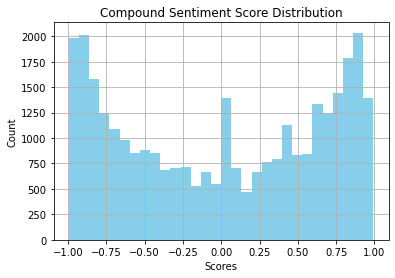

In [15]:
df.sentiment.hist(color='skyblue', bins=30)
plt.title('Compound Sentiment Score Distribution')
plt.xlabel('Scores')
plt.ylabel('Count')

([<matplotlib.axis.XTick at 0x23f77b50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

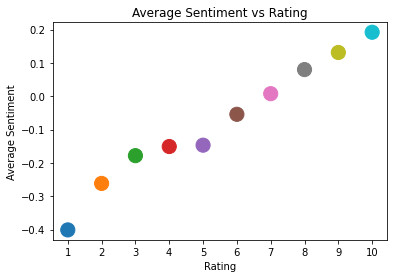

In [16]:
temp_ls = []

for i in range(1, 11):
    temp_ls.append(np.sum(df[df.effectiveness_rating == i].sentiment) / np.sum(df.effectiveness_rating == i))
    

plt.scatter(x=range(1, 11), y=temp_ls, c=range(1, 11), cmap='tab10', s=200)
plt.title('Average Sentiment vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment')
plt.xticks([i for i in range(1, 11)])

# Most common drugs

In [17]:
df

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,side effect take combination bystolic mg fish oil,9,20-May-12,27,8.022969,0.0000
1,95260,Guanfacine,ADHD,son halfway fourth week intuniv became concern...,8,27-Apr-10,192,7.858458,0.9068
2,92703,Lybrel,Birth Control,used take another oral contraceptive pill cycl...,5,14-Dec-09,17,6.341969,0.7506
3,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone completely turned life around feel he...,9,27-Nov-16,37,6.590176,0.9403
4,155963,Cialis,Benign Prostatic Hyperplasia,day started work rock hard erections however e...,2,28-Nov-15,43,6.144782,-0.6249
...,...,...,...,...,...,...,...,...,...
32160,183202,Cymbalta,Anxiety,taking cymbalta months first six months later ...,9,10-Jun-13,89,6.963020,-0.8750
32161,109111,Nexplanon,Birth Control,nexplanon since dec got first period end janua...,6,6-Apr-17,0,0.899076,0.7184
32162,121154,Venlafaxine,Panic Disorde,panic attacks social anxiety starting adolesce...,9,10-Nov-16,25,6.241812,-0.9781
32163,45410,Fluoxetine,Obsessive Compulsive Disorde,prozac weeks nowafter starting years ago terri...,8,21-Jan-15,22,7.940428,0.8417


there are 2220 name_of_drug out of 32165 records

In [18]:
name_of_drug = df.name_of_drug.value_counts().sort_values(ascending=False)
name_of_drug[:10]

Levonorgestrel                        724
Etonogestrel                          628
Ethinyl estradiol / norethindrone     547
Ethinyl estradiol / norgestimate      425
Nexplanon                             397
Ethinyl estradiol / levonorgestrel    394
Phentermine                           296
Sertraline                            281
Escitalopram                          265
Mirena                                241
Name: name_of_drug, dtype: int64

# most used drug_cases

In [19]:
df.use_case_for_drug.value_counts()

Birth Control                                    5795
Depression                                       1791
Pain                                             1273
Anxiety                                          1174
Acne                                             1101
                                                 ... 
Anemia Associated with Chronic Renal Failure        1
Mycobacterium avium-intracellulare, Treatment       1
Hepatocellular Carcinoma                            1
Renal Transplant                                    1
Body Imaging                                        1
Name: use_case_for_drug, Length: 636, dtype: int64

there are 636 use_case_for_drug out of 32165 records

In [20]:
use_case_for_drug = df.use_case_for_drug.value_counts().sort_values(ascending=False)
use_case_for_drug[:10]

Birth Control      5795
Depression         1791
Pain               1273
Anxiety            1174
Acne               1101
Bipolar Disorde     815
Insomnia            772
Obesity             727
Weight Loss         717
ADHD                627
Name: use_case_for_drug, dtype: int64

# Effectiveness_Rating_Distribution

([<matplotlib.axis.XTick at 0x23c73130>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

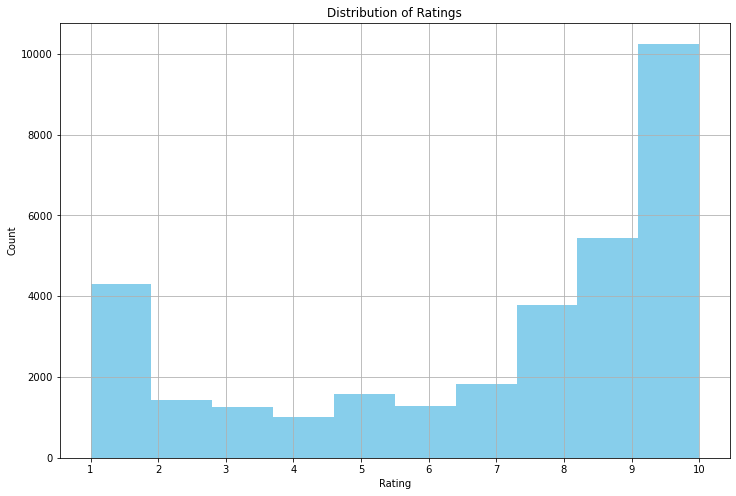

In [21]:
# Look at bias in review (also shown on 'Data' page in competition: distribution of ratings)
plt.rcParams['figure.figsize'] = [12, 8]
df.effectiveness_rating.hist(color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([i for i in range(1, 11)])

In [22]:
# Create a list (cast into an array) containing the average usefulness for given ratings
use_ls = []

for i in range(1, 11):
    use_ls.append([i, np.sum(df[df.effectiveness_rating == i].number_of_times_prescribed) / np.sum([df.effectiveness_rating == i])])
    
use_arr = np.asarray(use_ls)

([<matplotlib.axis.XTick at 0x245b64c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

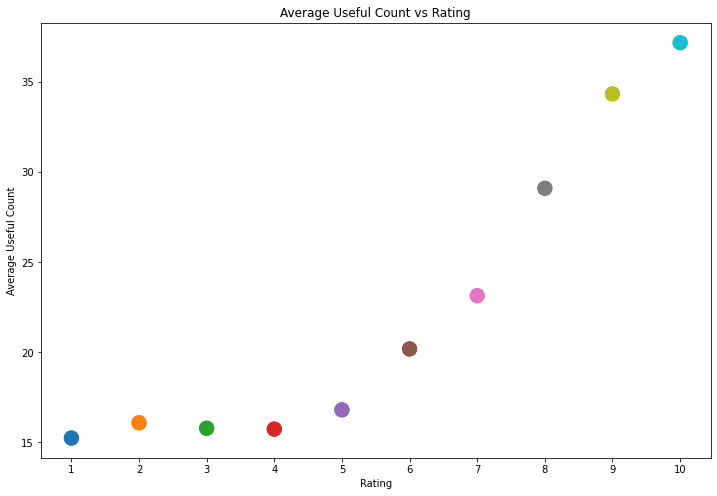

In [23]:
plt.scatter(use_arr[:, 0], use_arr[:, 1], c=use_arr[:, 0], cmap='tab10', s=200)
plt.title('Average Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Useful Count')
plt.xticks([i for i in range(1, 11)]);plt.scatter(use_arr[:, 0], use_arr[:, 1], c=use_arr[:, 0], cmap='tab10', s=200)
plt.title('Average Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Useful Count')
plt.xticks([i for i in range(1, 11)])

Looks like people found reviews with higher scores to be more useful!

In the sense that reviews with high ratings recieved more 'useful' tags than reviews with low ratings.

In [24]:
# Sort train dataframe from most to least useful
df = df.sort_values(by='number_of_times_prescribed', ascending=False)
df.iloc[:10]

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score,sentiment
404,62757,Citalopram,Depression,responded one week side effects lethargy bowel...,8,25-Mar-08,771,6.948738,-0.9246
31629,89689,Celexa,Depression,taking celexa months life completely different...,9,29-Jan-10,559,6.260555,-0.2729
10692,77107,Lorcaserin,Weight Loss,update one year experience belviq dropped poun...,10,21-Sep-14,556,8.755092,0.7269
23744,126310,Viibryd,Depression,atypical depression tried wellbutrin allergic ...,9,7-Sep-11,513,8.400719,-0.8578
13466,182492,Mirena,Birth Control,love mirena recommended several friends kids w...,10,1-Oct-08,505,8.412500,0.0777
28671,197749,Desvenlafaxine,Depression,trying several top ten antidepressants never f...,10,24-Jun-08,504,7.252806,0.4039
7063,138983,Phentermine,Weight Loss,lot people forum extremely unrealistic drug me...,8,18-Sep-09,476,6.494641,0.4939
16203,222844,Topamax,Obesity,topamax little less month already lost pounds ...,10,24-May-13,467,8.122917,-0.7037
22884,29632,Topiramate,Obesity,topamax little less month already lost pounds ...,10,24-May-13,467,8.122917,-0.7037
3943,151191,OxyContin,Pain,think tried every pain medication known man la...,10,12-Feb-10,463,8.024776,-0.5106


# Post Analysis i found that the Sentiment feature is not helping, also it has very less co-relation with the Target Varibale

Largely because of the names and the conditions of the disease, for example a use_of_drug is "Depression" but that will give a negative sentiment but at the same time can have High Base_score
Therefore dropping this column

In [28]:
#import the dataset train and test
train=pd.read_csv("train.csv")
test=pd.read_csv('test.csv')

In [29]:
#taking the target feature for training the model or we can say that dependent variable 
y = train[["base_score"]]

In [30]:
y.head()

,base_score
0,8.022969
1,7.858458
2,6.341969
3,6.590176
4,6.144782


In [31]:
#removing the column from the train set to make it as input set
del train["base_score"]

In [32]:
train.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43


In [34]:
#Taking the features from the train set accoring to the test set that make easy  to train the prediction model
train_data = train[["patient_id","name_of_drug","review_by_patient","drug_approved_by_UIC","number_of_times_prescribed","use_case_for_drug","effectiveness_rating"]]

In [35]:
#To know the data types of each feature of the dataset
train_data.dtypes

patient_id                     int64
name_of_drug                  object
review_by_patient             object
drug_approved_by_UIC          object
number_of_times_prescribed     int64
use_case_for_drug             object
effectiveness_rating           int64
dtype: object

In [36]:
#Encoding the text column values in train and test data set to numeric value 
from sklearn.preprocessing import LabelEncoder
ll=LabelEncoder()

In [38]:
#Encoding 
X_2 = train_data.apply(ll.fit_transform)
test_encoded = test.apply(ll.fit_transform)
X_2.head()

,patient_id,name_of_drug,review_by_patient,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug,effectiveness_rating
0,28649,2072,21000,1474,27,335,8
1,13333,923,23254,2213,192,39,7
2,13000,1212,15592,606,17,110,4
3,5042,332,25354,2305,37,412,8
4,21683,436,182,2420,43,105,1


In [39]:
test_encoded.head()

,patient_id,name_of_drug,review_by_patient,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug,effectiveness_rating
0,7573,854,7164,2058,22,130,9
1,1821,311,813,2640,35,441,8
2,9665,1471,81,2274,13,241,3
3,1051,821,7562,998,21,299,6
4,4427,66,909,442,44,231,1


# Data Visualization

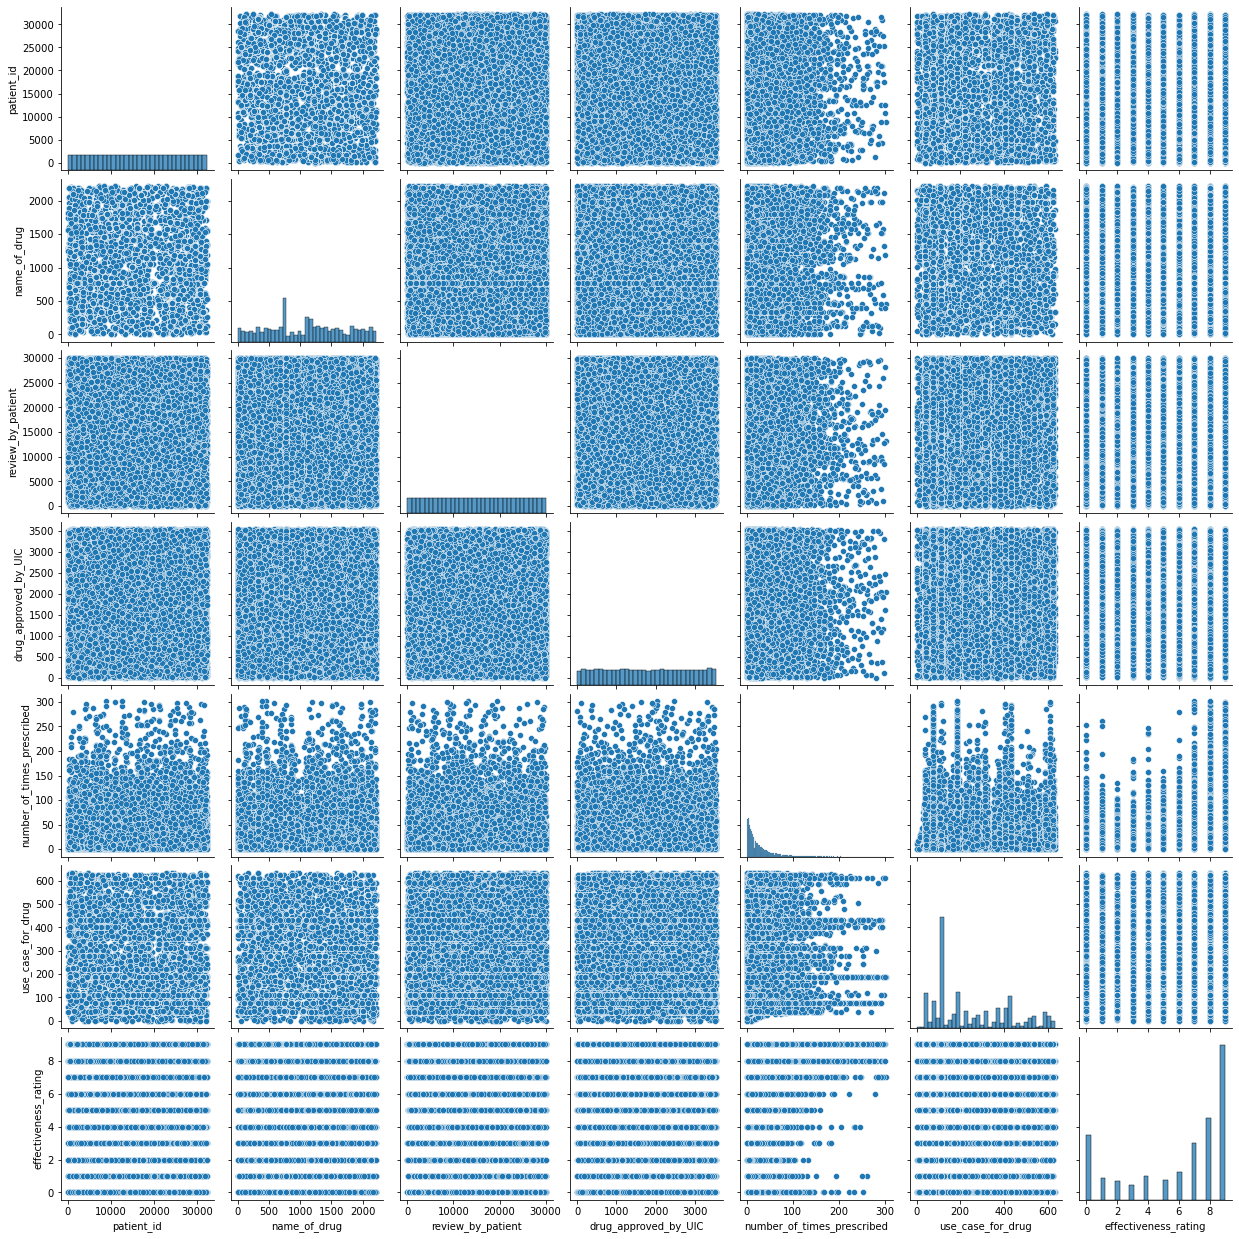

In [40]:
#Ploting the pairplot to the train dataset
sns.pairplot(X_2)

C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='effectiveness_rating', ylabel='Density'>

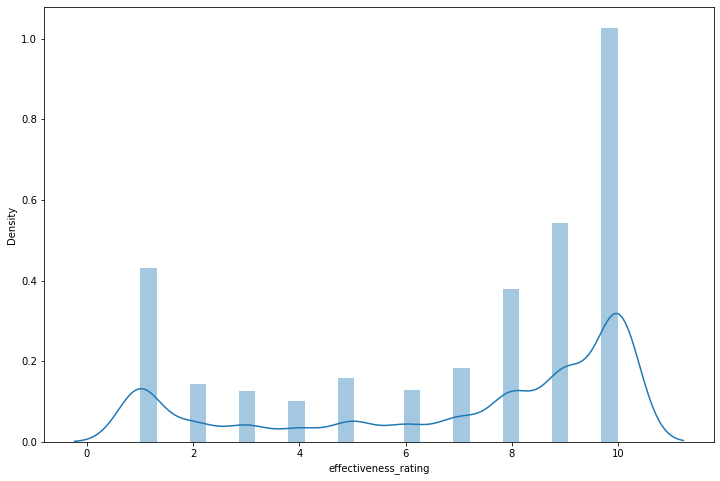

In [41]:
# Ploting the distribution plot on the effectiveness rating to know how it is distributed
sns.distplot(train['effectiveness_rating'])

In [42]:
#to know how the dataset is correlated with other columns
cor=X_2.corr()

<AxesSubplot:>

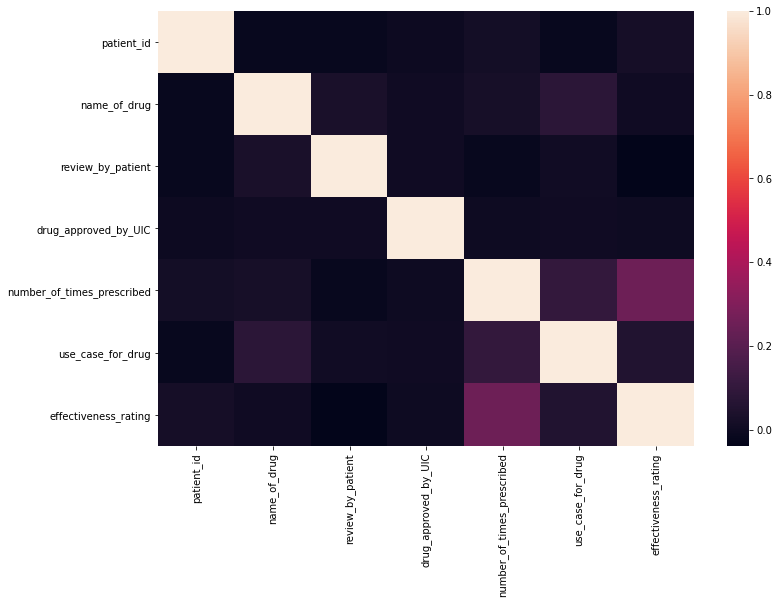

In [43]:
# correlation is presented by heatmeap to understand clearly 
sns.heatmap(cor)

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='name_of_drug', ylabel='number_of_times_prescribed'>

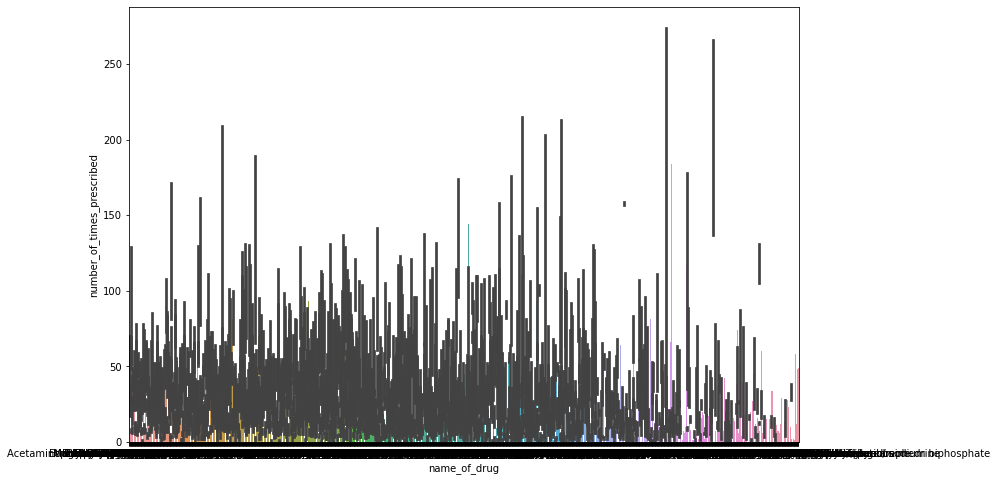

In [44]:
sns.barplot(train['name_of_drug'],train['number_of_times_prescribed'])

# Model Building

In [45]:
#Importing the prediction model from scikit library 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ridge_regression
from sklearn.neural_network import MLPRegressor

In [47]:
#initializing the models
m1 = LinearRegression()
m2 = AdaBoostRegressor()
m3=RandomForestRegressor(max_features='sqrt')
m4 = DecisionTreeRegressor()
#m5=ridge_regression()
m6 = MLPRegressor()

In [48]:
#Builiding  a ANN Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [49]:
model=Sequential()
model.add(Dense(4,kernel_initializer='uniform',activation='relu',input_dim=7))
model.add(Dense(4,kernel_initializer='uniform',activation='relu'))
model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))
model.compile(optimizer='adam',loss='mean_squared_error')

In [50]:
model.fit(X_2,y,batch_size=2,epochs=5)

Epoch 1/5
16083/16083 [==============================] - 30s 2ms/step - loss: 34.7760
Epoch 2/5
16083/16083 [==============================] - 28s 2ms/step - loss: 34.6077
Epoch 3/5
16083/16083 [==============================] - 28s 2ms/step - loss: 34.6077
Epoch 4/5
16083/16083 [==============================] - 28s 2ms/step - loss: 34.6078
Epoch 5/5
16083/16083 [==============================] - 28s 2ms/step - loss: 34.6078


In [51]:
#fitting the input data to the model or training the data to model
m1.fit(X_2,y)
m2.fit(X_2,y)
m3.fit(X_2,y)
m4.fit(X_2,y)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-51-dd103d3f4f63>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m3.fit(X_2,y)


DecisionTreeRegressor()

In [52]:
m6.fit(X_2,y)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor()

In [53]:
#making predicton on the test set 
pred1 = m1.predict(test_encoded)

In [54]:
pred2 = m2.predict(test_encoded)

In [55]:
pred3 = m3.predict(test_encoded)

In [56]:
pred4 = m4.predict(test_encoded)

In [57]:
mlp=m6.predict(test_encoded)

In [66]:
ann=model.predict(test_encoded)

In [67]:
ann

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [58]:
pred1

array([[7.25620384],
       [7.05271222],
       [6.06823322],
       ...,
       [7.28887258],
       [6.82896705],
       [7.05349983]])

In [59]:
pred2

array([7.51570351, 7.51570351, 6.87025699, ..., 7.51570351, 6.515391  ,
       7.51570351])

In [60]:
pred3

array([7.94880606, 7.53872397, 6.52767229, ..., 7.3915113 , 5.29257471,
       7.92271588])

In [61]:
pred4

array([8.75720098, 8.74503683, 5.95227783, ..., 6.78824482, 5.30523211,
       8.19393369])

In [62]:
mlp

array([7.00380882, 1.57349127, 5.32715169, ..., 7.01900485, 5.26117832,
       5.91515745])

In [63]:
#making predicted value like submission sample value
pred1=[pred1.round(2)]

In [64]:
#making predicted value like submission sample value
pred2=[pred2.round(2)]

In [65]:
#making predicted value like submission sample value
pred3=[pred3.round(2)]

In [68]:
ann=[ann.round(2)]

In [69]:
ann

[array([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], dtype=float32)]

In [71]:
#of pred3
#making a DataFrame for submission file to store the result 
submission = pd.DataFrame()
submission['patient_id'] = test['patient_id']
submission['base_score'] = pred3[0] # our model predictions on the test dataset
#submission.head()
submission.to_csv('submission2.csv', index=False)
print('Saved the submission file')

Saved the submission file


In [73]:
result = pd.read_csv('submission2.csv')
result

,patient_id,base_score
0,163740,7.95
1,39293,7.54
2,208087,6.53
3,23295,5.04
4,97013,6.76
...,...,...
10755,151266,6.15
10756,139347,5.05
10757,159999,7.39
10758,130945,5.29
